### Visualize results from single point mimics simulation using Anderson Acceleration
Will Wieder Oct 2024

In [1]:
%load_ext autoreload
%autoreload 2

from glob import glob
from os.path import join

import calendar

import tqdm
import cftime
import dask

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import cm

from distributed import wait

import warnings
warnings.simplefilter("ignore", category=FutureWarning)

%matplotlib inline

In [10]:
# -- read only these variables from the whole netcdf files
def preprocess (ds):
    variables = ['TOTSOMC','TOTSOMN',
                 #'TOTLITC','TOTMICC','TOTLITN','TOTMICN',
                 'LIT_MET_C_vr','LIT_STR_C_vr',
                 'MIC_COP_C_vr','MIC_OLI_C_vr',
                 'SOM_AVL_C_vr', 'SOM_CHEM_C_vr', 'SOM_PHYS_C_vr',
                 'TOTVEGC','TOTECOSYSC','GPP',
                 #'AR','HR',
                 #'TSOI','H2OSOI',
                ]

    ds_new= ds[variables]
    ds_new['TOT_SOM_C_vr']= ds_new.SOM_AVL_C_vr + ds_new.SOM_CHEM_C_vr + ds_new.SOM_PHYS_C_vr
    ds_new['TOT_SOM_C_vr'].attrs['units'] = ds_new['SOM_AVL_C_vr'].attrs['units']
    ds_new['TOT_LIT_C_vr']= ds_new.LIT_MET_C_vr + ds_new.LIT_STR_C_vr 
    ds_new['TOT_LIT_C_vr'].attrs['units'] = ds_new['LIT_MET_C_vr'].attrs['units']
    ds_new['TOT_MIC_C_vr']= ds_new.MIC_COP_C_vr + ds_new.MIC_OLI_C_vr 
    ds_new['TOT_MIC_C_vr'].attrs['units'] = ds_new['MIC_COP_C_vr'].attrs['units']

    return ds_new

In [11]:
# -- fix timestamp on CTSM files so they can be matched with eval files
def fix_time (ds):
    '''
    fix time formatting with reading multiple cesm files.
    '''
    nsteps = len(ds.time)
    yr0 = ds['time.year'][0].values
    month0 = ds['time.month'][0].values
    day0 = ds['time.day'][0].values

    date = cftime.datetime(yr0,month0,day0).isoformat() 
    ds['time'] = xr.cftime_range(date, periods=nsteps, freq='30min')
    ds['time']= ds['time'].dt.strftime("%Y-%m-%d %H:%M:%S")
    return ds

def fix_time_h0 (ds, MIM = False):
    nsteps = len(ds.time)
    yr0 = ds['time.year'][0].values
    if yr0 < 1800:
        yr0 = yr0+400
    month0 = ds['time.month'][0].values - 1 
    day0=1
    date = cftime.datetime(yr0,month0,day0).isoformat() 
    ds['time'] = xr.cftime_range(date, periods=nsteps, freq='M')
    return ds

### Define sites, data paths, & open files

In [12]:
path = '/glade/derecho/scratch/wwieder/AA_mimics/'
neon_sites2 = ['TOOL'] # for testing
failed_sites = [] # -- list for saving failed sites
years = ['1-01-01-00000.nc'] # just read 1 year / decade
cases = [neon_sites2[0] + '_init',
         neon_sites2[0] + '_mimics_DI',
        ]

for neon_site in neon_sites2:
    try:
        ts_files0, ts_files1 = [], []
        path0 = path + cases[0] + '/run'
        path1 = path + 'archive/' + cases[1] + '/lnd/hist/'

        for year in years:
            ts_files0.extend(sorted(glob(join(path0, cases[0] + ".clm2.h0.*.nc" ))))
            ts_files1.extend(sorted(glob(join(path1, cases[1] + ".clm2.h0.*" + year))))

        print('ts files0 '+ts_files0[-1])
        print("All time series files0: [", len(ts_files0), "files]")
        print("All time series files1: [", len(ts_files1), "files]")
        print ('---------------------------')
        print ("Reading data for "+neon_site)

        # Read in datasets
        ds0 = xr.open_mfdataset(ts_files0, decode_times=True, combine='by_coords', 
                                parallel=True,preprocess=preprocess)
        ds1 = xr.open_mfdataset(ts_files1, decode_times=True, combine='by_coords', 
                                parallel=True,preprocess=preprocess)
        print(' ** finished time series ** ')

    except Exception as e: 
        print (e)
        print ('THIS SITE FAILED:', neon_site)
        failed_sites.append(neon_site)
        pass


ts files0 /glade/derecho/scratch/wwieder/AA_mimics/TOOL_init/run/TOOL_init.clm2.h0.0417-01-01-00000.nc
All time series files0: [ 317 files]
All time series files1: [ 600 files]
---------------------------
Reading data for TOOL
 ** finished time series ** 


In [13]:
ds0 = ds0.isel(gridcell=0)
ds1 = ds1.isel(gridcell=0)

In [14]:
ds1

<xarray.Dataset> Size: 497kB
Dimensions:        (time: 600, levsoi: 20)
Coordinates:
  * levsoi         (levsoi) float32 80B 0.01 0.04 0.09 0.16 ... 5.95 6.94 8.03
  * time           (time) object 5kB 0111-01-01 00:00:00 ... 6101-01-01 00:00:00
Data variables: (12/15)
    TOTSOMC        (time) float32 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    TOTSOMN        (time) float32 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    LIT_MET_C_vr   (time, levsoi) float32 48kB dask.array<chunksize=(1, 20), meta=np.ndarray>
    LIT_STR_C_vr   (time, levsoi) float32 48kB dask.array<chunksize=(1, 20), meta=np.ndarray>
    MIC_COP_C_vr   (time, levsoi) float32 48kB dask.array<chunksize=(1, 20), meta=np.ndarray>
    MIC_OLI_C_vr   (time, levsoi) float32 48kB dask.array<chunksize=(1, 20), meta=np.ndarray>
    ...             ...
    TOTVEGC        (time) float32 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    TOTECOSYSC     (time) float32 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    GPP            (time) float32 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    TOT_SOM_C_vr   (time, levsoi) float32 48kB dask.array<chunksize=(1, 20), meta=np.ndarray>
    TOT_LIT_C_vr   (time, levsoi) float32 48kB dask.array<chunksize=(1, 20), meta=np.ndarray>
    TOT_MIC_C_vr   (time, levsoi) float32 48kB dask.array<chunksize=(1, 20), meta=np.ndarray>
Attributes: (12/101)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 09/08/24 07:48:35
    source:                               Community Terrestrial Systems Model
    hostname:                             derecho
    ...                                   ...
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     day_365
    Time_constant_3Dvars_filename:        ./TOOL_mimics_DI.clm2.h0.0107-01-01...
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT:...

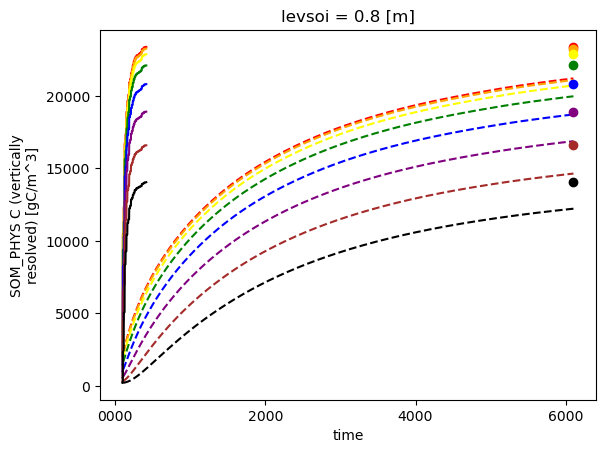

In [15]:
var = 'SOM_PHYS_C_vr'
colors = ['red','orange','yellow','green','blue','purple','brown','black',
         'red','orange','yellow','green','blue','purple','brown','black']
for i in range(8):
    ds0[var].isel(levsoi=i).plot(color=colors[i])
    ds1[var].isel(levsoi=i).plot(color=colors[i], linestyle='dashed')
    plt.plot(ds1.time.max(),ds0[var].isel(levsoi=i).max(),'o',color=colors[i])


In [16]:
#name = "Accent"
#cmap = plt.colormaps[name]  # type: matplotlib.colors.ListedColormap
#colors = cmap.colors  # type: list
#ax.set_prop_cycle(color=colors)
#alt: hard code colors
colors=['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
    '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5']

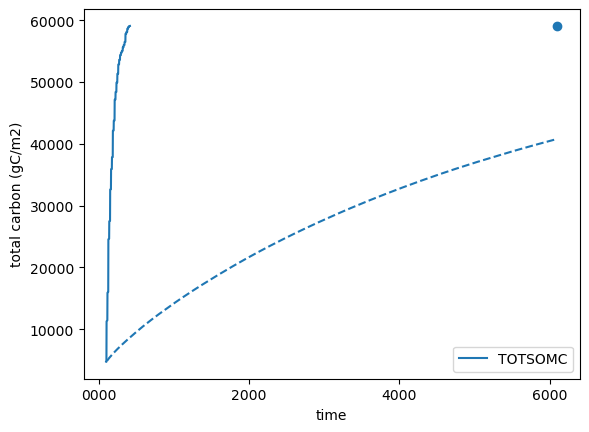

In [17]:
vars = ['TOTSOMC','TOTLITC','TOTMICC']
vars = ['TOTSOMC']
i =0
for var in vars:
    ds0[var].plot(color=colors[i],label=var)
    ds1[var].plot(color=colors[i], linestyle='dashed')
    plt.plot(ds1.time.max(),ds0[var].max(),'o',color=colors[i])
    i = i+1
plt.ylabel('total carbon (gC/m2)')
plt.legend() ;

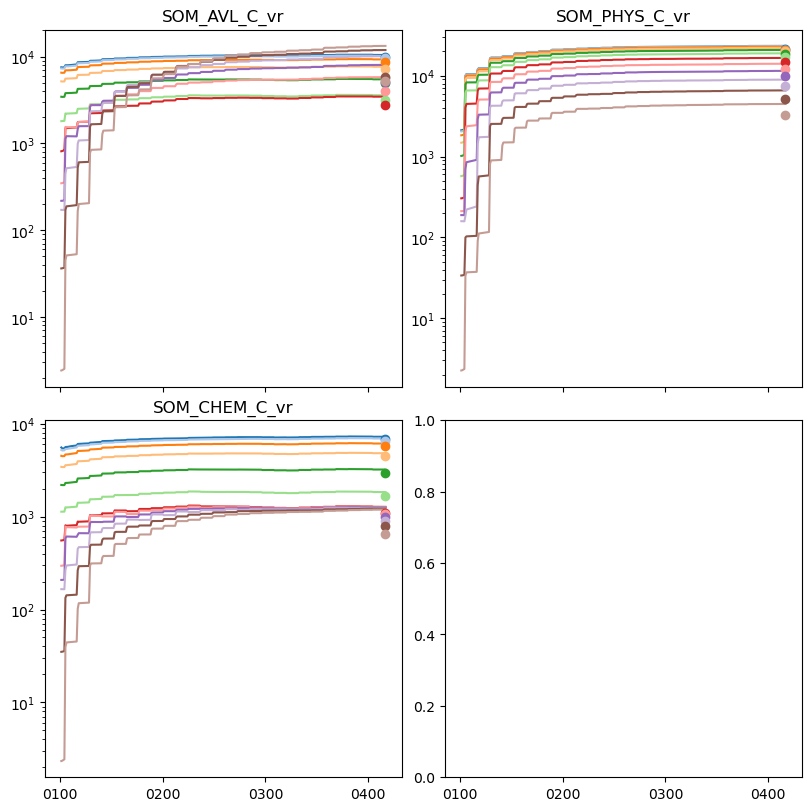

In [18]:
vars = ['SOM_AVL_C_vr','SOM_CHEM_C_vr','SOM_PHYS_C_vr']
#vars = ['TOT_SOM_C_vr','TOT_LIT_C_vr','TOT_MIC_C_vr','TOTSOMC']
fig, axes = plt.subplots(2, 2, sharex = True, figsize=(8, 8),
                         layout='constrained')
x = 0
y = 0
nlev = 12
for var in vars:
    ax = axes[x,y]
    ax.set_prop_cycle(color=colors)
    ax.set_yscale("log")
    ax.set_title(var)
    if var == 'TOTSOMC':
        ax.plot(ds0.time,ds0[var])
        #ax.plot(ds0.time,ds0['TOTLITC'])
        #ax.plot(ds0.time,ds0['TOTMICC'])
        ax.plot(ds0.time.max(),ds1[var].isel(time=-1),'o',color=colors[0])
    else:
        ax.plot(ds0.time,ds0[var].isel(levsoi=slice(0,nlev)))
        for i in range(nlev):
            ax.plot(ds0.time.max(),ds1[var].isel(levsoi=i,time=-1),'o', color=colors[i], 
                    label=ds0.levsoi.isel(levsoi=i).values)
    x = x + 1
    if x == 2:
        y = y + 1
        x = 0
    if var == 'TOT_LIT_C_vr':
        ax.legend()
fig.show()

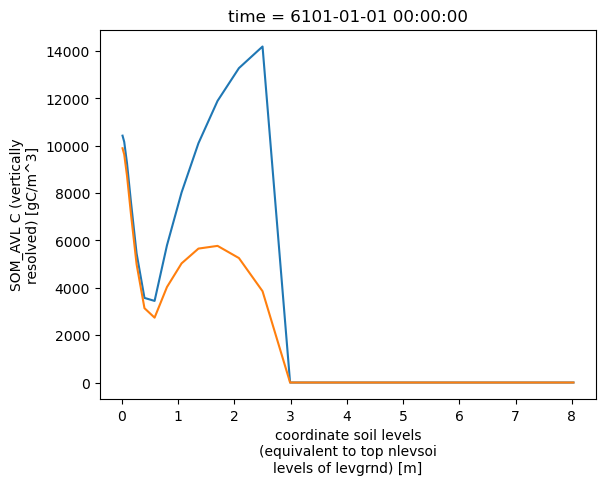

In [19]:
ds0['SOM_AVL_C_vr'].isel(time=-1).plot()
ds1['SOM_AVL_C_vr'].isel(time=-1).plot() ;

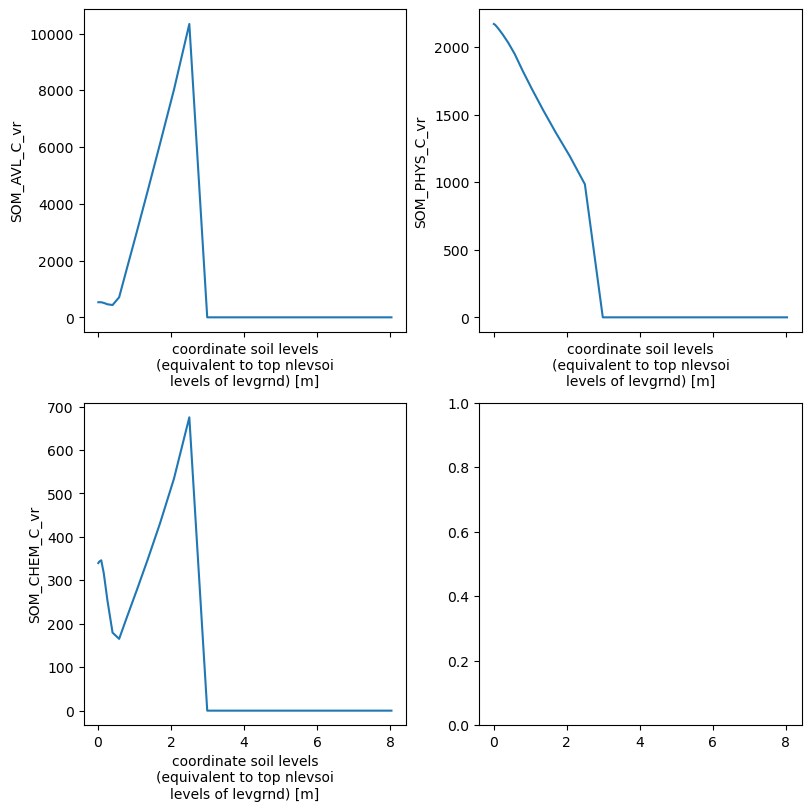

In [20]:
fig, axes = plt.subplots(2, 2, sharex = True, figsize=(8, 8),
                         layout='constrained')
x = 0
y = 0
for var in vars:
    (ds0[var].isel(time=-1) - ds1[var].isel(time=-1)).plot(ax = axes[x,y])
    x = x + 1
    if x == 2:
        y = y + 1
        x = 0

## Check MIMICS spinup

In [106]:
ds0

<xarray.Dataset> Size: 124kB
Dimensions:        (time: 146, levsoi: 20)
Coordinates:
  * levsoi         (levsoi) float32 80B 0.01 0.04 0.09 0.16 ... 5.95 6.94 8.03
  * time           (time) object 1kB 0103-01-01 00:00:00 ... 0248-01-01 00:00:00
Data variables: (12/21)
    TOTLITC        (time) float32 584B dask.array<chunksize=(1,), meta=np.ndarray>
    TOTMICC        (time) float32 584B dask.array<chunksize=(1,), meta=np.ndarray>
    TOTSOMC        (time) float32 584B dask.array<chunksize=(1,), meta=np.ndarray>
    TOTLITN        (time) float32 584B dask.array<chunksize=(1,), meta=np.ndarray>
    TOTMICN        (time) float32 584B dask.array<chunksize=(1,), meta=np.ndarray>
    TOTSOMN        (time) float32 584B dask.array<chunksize=(1,), meta=np.ndarray>
    ...             ...
    GPP            (time) float32 584B dask.array<chunksize=(1,), meta=np.ndarray>
    AR             (time) float32 584B dask.array<chunksize=(1,), meta=np.ndarray>
    HR             (time) float32 584B dask.array<chunksize=(1,), meta=np.ndarray>
    TOT_SOM_C_vr   (time, levsoi) float32 12kB dask.array<chunksize=(1, 20), meta=np.ndarray>
    TOT_LIT_C_vr   (time, levsoi) float32 12kB dask.array<chunksize=(1, 20), meta=np.ndarray>
    TOT_MIC_C_vr   (time, levsoi) float32 12kB dask.array<chunksize=(1, 20), meta=np.ndarray>
Attributes: (12/99)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 09/11/24 05:46:01
    source:                               Community Terrestrial Systems Model
    hostname:                             derecho
    ...                                   ...
    cft_irrigated_switchgrass:            60
    cft_tropical_corn:                    61
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     day_365

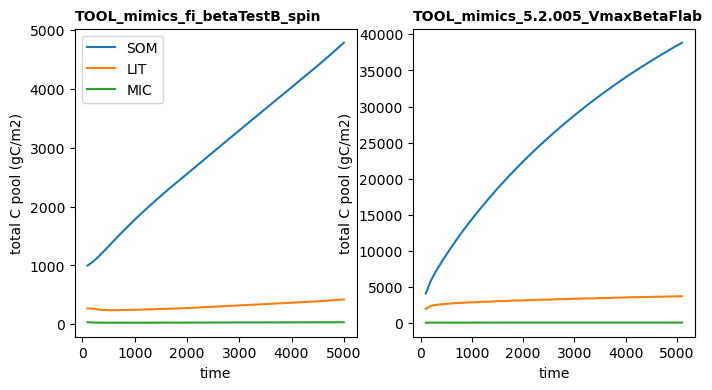

In [16]:
plt.figure(figsize=[8,4])
plt.subplot(1, 2, 1)
ds0.TOTSOMC.plot(label='SOM')
ds0.TOTLITC.plot(label='LIT')
ds0.TOTMICC.plot(label='MIC')
plt.ylabel('total C pool (gC/m2)')
plt.title(cases[0], loc='left', fontsize='medium', fontweight='bold')
plt.legend() ;

plt.subplot(1, 2, 2)
ds1.TOTSOMC.plot(label='SOM')
ds1.TOTLITC.plot(label='LIT')
ds1.TOTMICC.plot(label='MIC')
plt.ylabel('total C pool (gC/m2)')
plt.title(cases[1], loc='left', fontsize='medium', fontweight='bold') ;

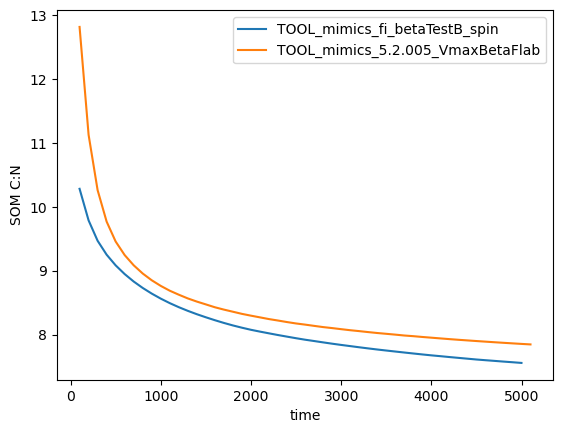

In [17]:
(ds0.TOTSOMC/ds0.TOTSOMN).plot(label=cases[0])
(ds1.TOTSOMC/ds1.TOTSOMN).plot(label=cases[1])
#(ds2.TOTSOMC/ds2.TOTSOMN).plot(label=cases[2]) 
#(ds3.TOTSOMC/ds3.TOTSOMN).plot(label=cases[3]) 
plt.ylabel('SOM C:N')
plt.legend() ;

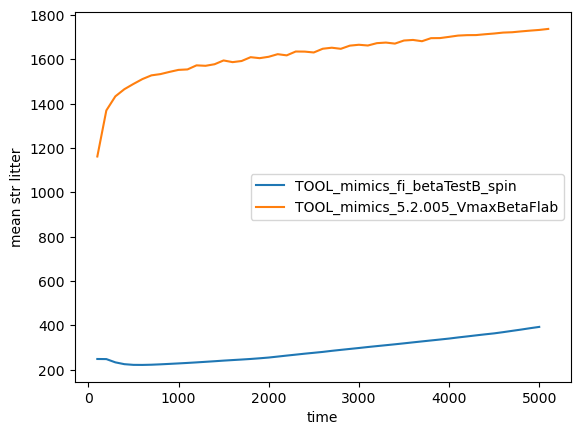

In [18]:
ds0.LIT_STR_C_vr.mean('levsoi').plot(label=cases[0])
ds1.LIT_STR_C_vr.mean('levsoi').plot(label=cases[1])
#ds2.LIT_STR_C_vr.mean('levsoi').plot(label=cases[2])
#ds3.LIT_STR_C_vr.mean('levsoi').plot(label=cases[3])
plt.ylabel('mean str litter')
plt.legend() ;

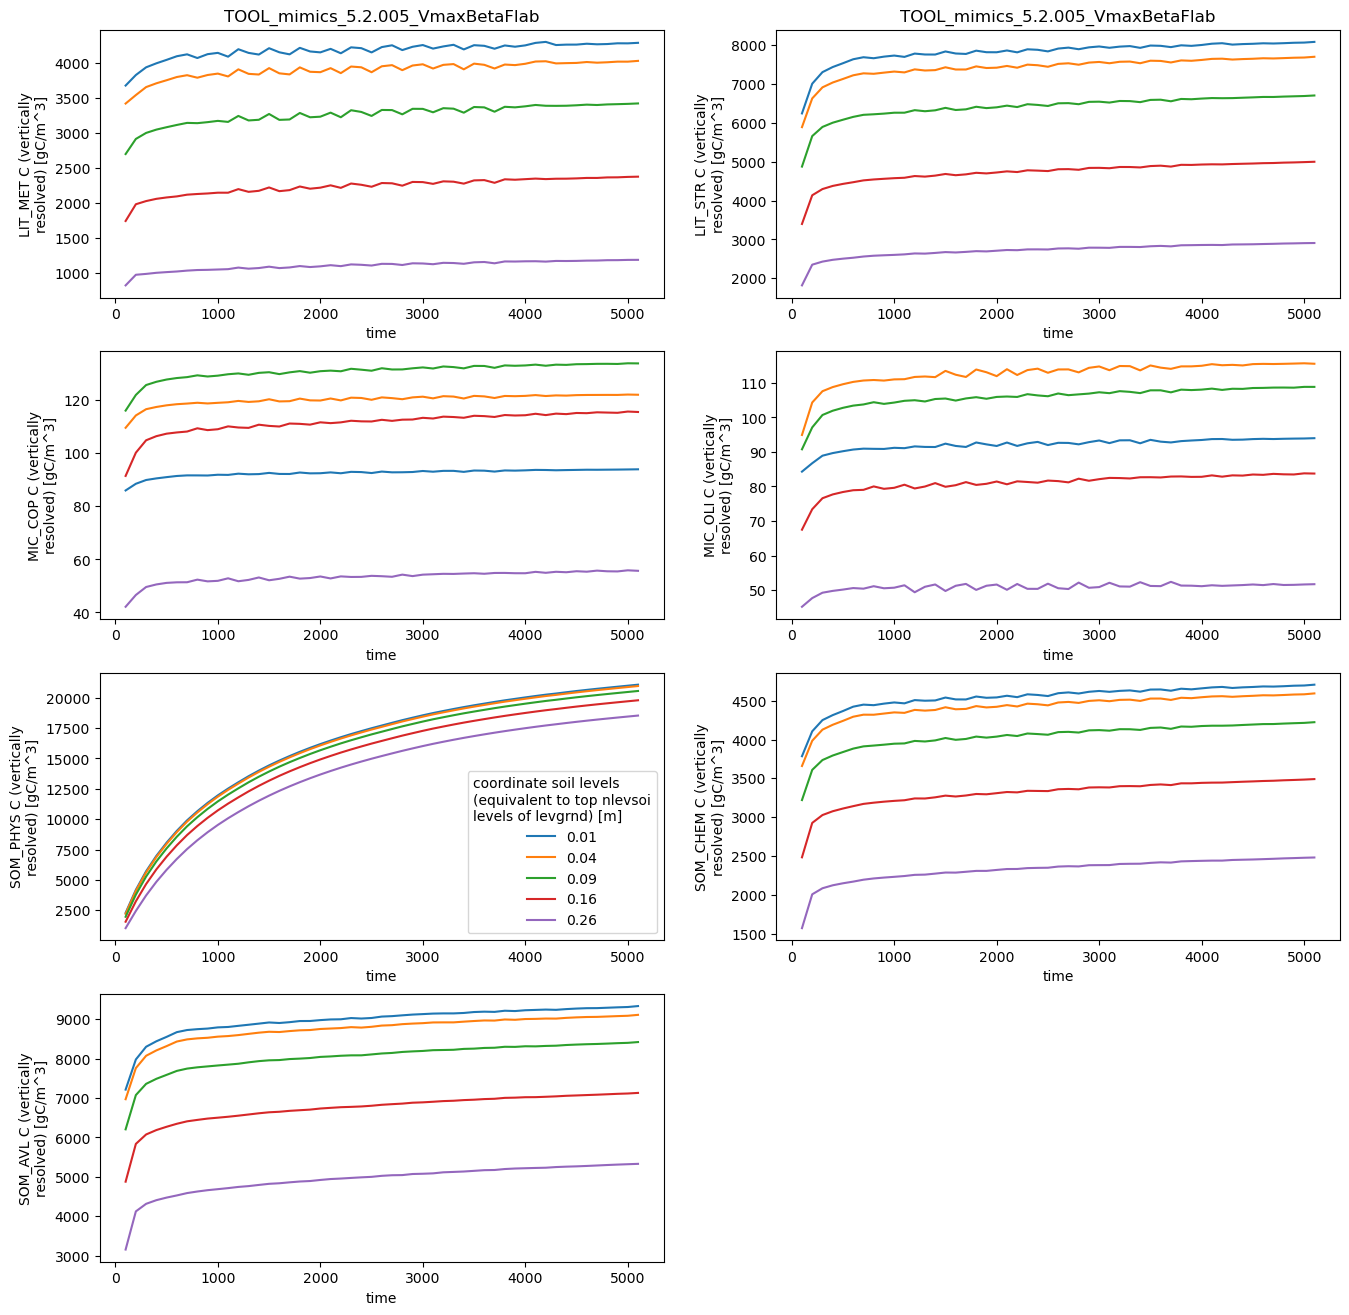

In [19]:
plt.figure(figsize=[16,16])
var=['LIT_MET_C_vr','LIT_STR_C_vr',
     'MIC_COP_C_vr','MIC_OLI_C_vr',
     'SOM_PHYS_C_vr','SOM_CHEM_C_vr','SOM_AVL_C_vr']
for i in range(len(var)):
    plt.subplot(4, 2, (1+i))
    if i != 4: ds1[var[i]].isel(levsoi=slice(0,5)).plot(hue='levsoi',add_legend=False) 
    else: ds1[var[i]].isel(levsoi=slice(0,5)).plot(hue='levsoi',add_legend=True)
    if i <= 1: plt.title(cases[1])
    #plt.yscale('log',base=10) 

In [20]:
### Lots of SOMa, is parameterization working as expected, check KO

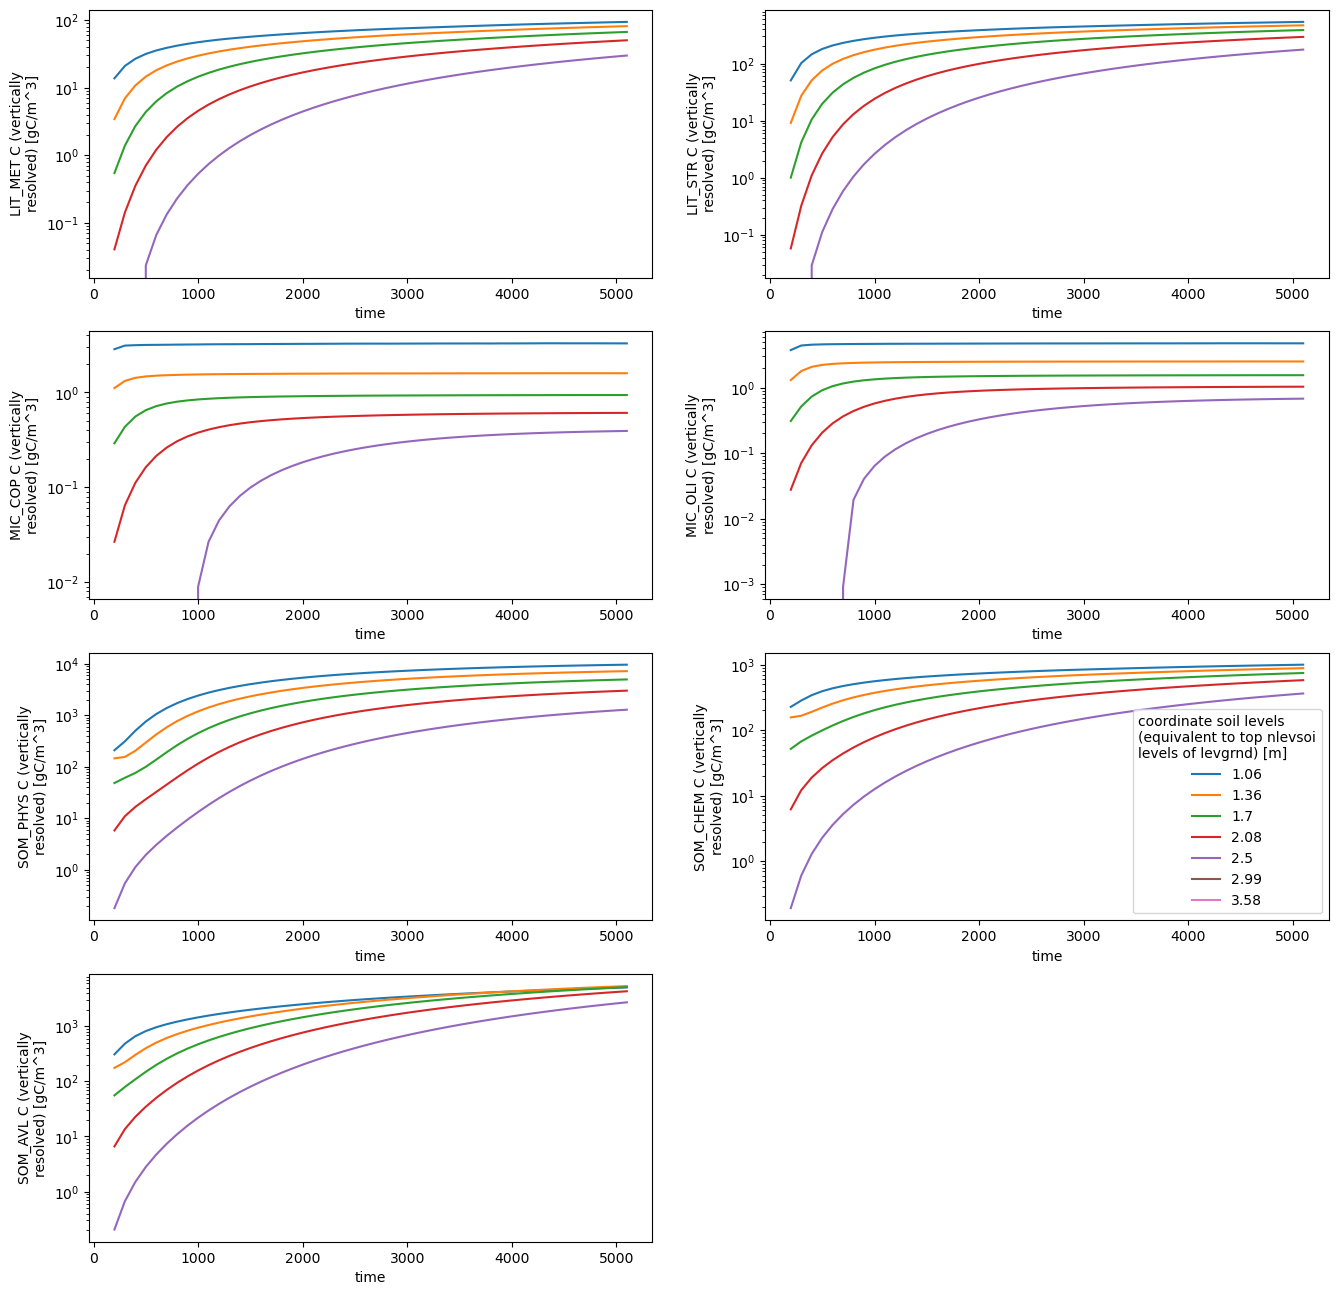

In [21]:
plt.figure(figsize=[16,16])
ftime=1 #skip first 100 time steps
for i in range(len(var)):
    plt.subplot(4, 2, (1+i))
    if i != 5: ds1[var[i]].isel(levsoi=slice(8,15),time=slice(ftime,None)).plot(hue='levsoi',add_legend=False) 
    else: ds1[var[i]].isel(levsoi=slice(8,15),time=slice(ftime,None)).plot(hue='levsoi',add_legend=True)
    plt.yscale('log',base=10) 

### If there's no microbial biomass in lower horizons, LIT and SOM pools accumulating

### Look at 

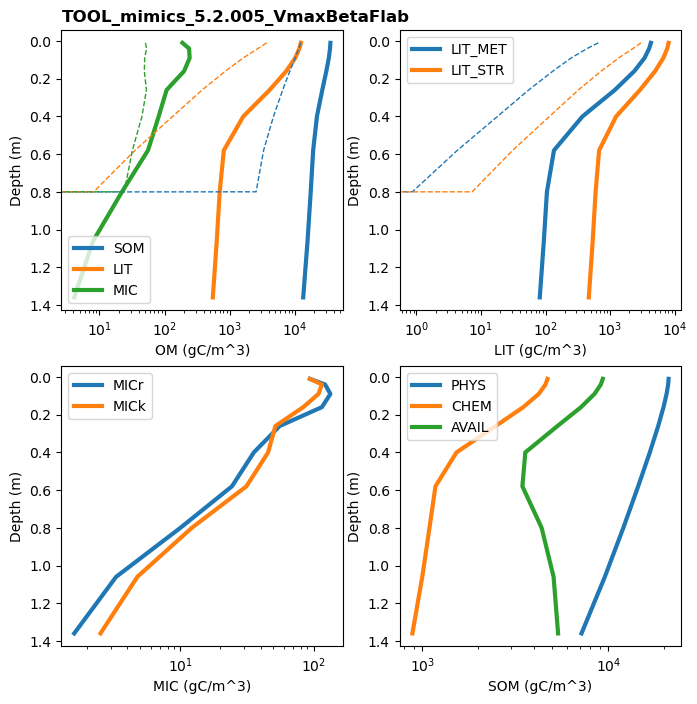

In [22]:
plt.figure(figsize=[8,8])
nbot = 10

plt.subplot(2, 2, 1)
x = ds1.TOT_SOM_C_vr.isel(time=-1).isel(levsoi=slice(0,nbot))
x2 = ds1.TOT_LIT_C_vr.isel(time=-1).isel(levsoi=slice(0,nbot))
x3 = ds1.TOT_MIC_C_vr.isel(time=-1).isel(levsoi=slice(0,nbot))
y = ds1.levsoi.isel(levsoi=slice(0,nbot))
plt.plot(x,y,lw=3,label='SOM') 
plt.plot(x2,y,lw=3,label='LIT') 
plt.plot(x3,y,lw=3,label='MIC') 
plt.xlabel('OM ('+ds1.TOT_SOM_C_vr.attrs['units']+')')
plt.ylabel('Depth (m)')
plt.title(cases[1], loc='left', fontsize='large', fontweight='bold') ;
plt.xscale('log',base=10) 
plt.legend()
plt.gca().invert_yaxis() ;
# ADD CONTROL CASE
x = ds0.TOT_SOM_C_vr.isel(time=-1).isel(levsoi=slice(0,nbot))
x2 = ds0.TOT_LIT_C_vr.isel(time=-1).isel(levsoi=slice(0,nbot))
x3 = ds0.TOT_MIC_C_vr.isel(time=-1).isel(levsoi=slice(0,nbot))
y = ds0.levsoi.isel(levsoi=slice(0,nbot))
plt.plot(x, y, lw=1, linestyle='--', color='tab:blue')
plt.plot(x2, y, lw=1, linestyle='--', color='tab:orange')
plt.plot(x3, y, lw=1, linestyle='--', color='tab:green')


plt.subplot(2, 2, 2)
x = ds1.LIT_MET_C_vr.isel(time=-1).isel(levsoi=slice(0,nbot))#*1e-3#.plot();
x2 = ds1.LIT_STR_C_vr.isel(time=-1).isel(levsoi=slice(0,nbot))#*1e-3#.plot();
y = ds1.levsoi.isel(levsoi=slice(0,nbot))
plt.plot(x,y,lw=3,label='LIT_MET') 
plt.plot(x2,y,lw=3,label='LIT_STR') 
plt.xlabel('LIT ('+ds1.LIT_MET_C_vr.attrs['units']+')')
plt.ylabel('Depth (m)')
plt.xscale('log',base=10) 
plt.legend()
plt.gca().invert_yaxis() ;
# ADD CONTROL CASE
x = ds0.LIT_MET_C_vr.isel(time=-1).isel(levsoi=slice(0, nbot))
x2 = ds0.LIT_STR_C_vr.isel(time=-1).isel(levsoi=slice(0, nbot))
y = ds0.levsoi.isel(levsoi=slice(0,nbot))
plt.plot(x, y, lw=1, linestyle='--', color='tab:blue')
plt.plot(x2, y, lw=1, linestyle='--', color='tab:orange')

plt.subplot(2, 2, 3)
x = ds1.MIC_COP_C_vr.isel(time=-1).isel(levsoi=slice(0,nbot))#*1e-3#.plot();
x2 = ds1.MIC_OLI_C_vr.isel(time=-1).isel(levsoi=slice(0,nbot))#*1e-3#.plot();
y = ds1.levsoi.isel(levsoi=slice(0,nbot))
plt.plot(x,y,lw=3,label='MICr') 
plt.plot(x2,y,lw=3,label='MICk') 
plt.xlabel('MIC ('+ds1.MIC_COP_C_vr.attrs['units']+')')
plt.ylabel('Depth (m)')
plt.xscale('log',base=10) 
plt.legend()
plt.gca().invert_yaxis() ;

plt.subplot(2, 2, 4)
x = ds1.SOM_PHYS_C_vr.isel(time=-1).isel(levsoi=slice(0,nbot))#*1e-3#.plot();
x2 = ds1.SOM_CHEM_C_vr.isel(time=-1).isel(levsoi=slice(0,nbot))#*1e-3#.plot();
x3 = ds1.SOM_AVL_C_vr.isel(time=-1).isel(levsoi=slice(0,nbot))#*1e-3#.plot();
y = ds1.levsoi.isel(levsoi=slice(0,nbot))
plt.plot(x,y,lw=3,label='PHYS') 
plt.plot(x2,y,lw=3,label='CHEM') 
plt.plot(x3,y,lw=3,label='AVAIL') 
plt.xlabel('SOM ('+ds1.SOM_AVL_C_vr.attrs['units']+')')
plt.ylabel('Depth (m)')
plt.xscale('log',base=10) 
plt.legend()
plt.gca().invert_yaxis() ;



In the original (default) case I was not really happy with the depth dynamics of CHEM and AVAIL pools, which likely are reflecting common microbial kinnetics through the profile. For example, Ying-Ping's 2014 paper suggested the following steady state soil C pool for a 3-pool model

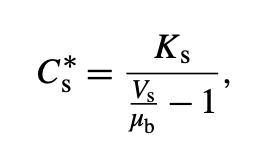.

Should turnover be depth dependent, based on inputs?
Switching to the beta function seems to improve this, but is also makes depth profiles of MICr:MICk more similar.

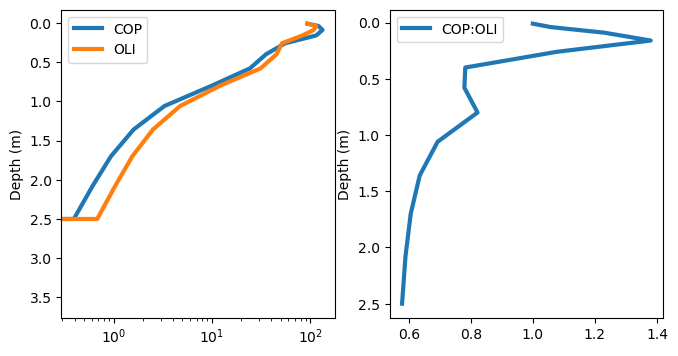

In [23]:
plt.figure(figsize=[12,4])
nbot = 15

plt.subplot(1, 3, 1)
# More oligotrophs at depth!
x = ds1.MIC_COP_C_vr.isel(time=-1,levsoi=slice(0,nbot)) 
x2 = ds1.MIC_OLI_C_vr.isel(time=-1,levsoi=slice(0,nbot))
y = ds1.levsoi.isel(levsoi=slice(0,nbot))

plt.plot(x,y,lw=3,label='COP') 
plt.plot(x2,y,lw=3,label='OLI') 
plt.ylabel('Depth (m)')
plt.legend()
plt.xscale('log',base=10) 
plt.gca().invert_yaxis() ;

plt.subplot(1, 3, 2)
x = (ds1.MIC_COP_C_vr.isel(time=-1) / ds1.MIC_OLI_C_vr.isel(time=-1)).isel(levsoi=slice(0,nbot))

plt.plot(x,y,lw=3,label='COP:OLI') 
plt.ylabel('Depth (m)')
plt.legend()
plt.gca().invert_yaxis() ;

In [18]:
pathIN = '/glade/campaign/cgd/tss/slevis/ctsm_offline/cases_mimics/'
pathINcen = pathIN +'init_stock_1_test/200_and_400_yrs/lnd/hist/'

# read in every 10 years from CENTURY spinup
adIN = pathINcen + 'adspinup/*0-01-01-00000.nc'
padIN = pathINcen + 'post_ad/*0-01-01-00000.nc'
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ad = xr.open_mfdataset(adIN)
    pad = xr.open_mfdataset(padIN)

OSError: no files to open

In [5]:
adIN

'/glade/campaign/cgd/tss/slevis/ctsm_offline/cases_mimics/init_stock_1_test/200_and_400_yrs/lnd/hist/adspinup/*0-01-01-00000.nc'

No handles with labels found to put in legend.


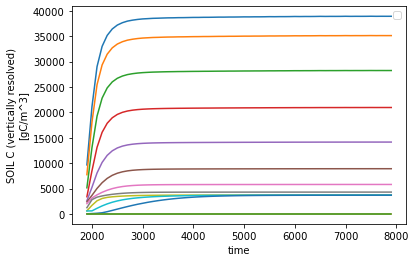

In [91]:
mim.SOILC_vr.isel(levsoi=slice(0,13)).plot(hue='levsoi') ;
plt.legend() ;


In [47]:
mim.SOILC_vr.isel(time=-1).values#.plot();

array([38918.766 , 35115.88  , 28237.92  , 20955.25  , 14148.357 ,
        8902.155 ,  5801.473 ,  4297.0117,  3720.3672,  3706.0095,
        3687.863 ,     0.    ,     0.    ,     0.    ,     0.    ,
           0.    ,     0.    ,     0.    ,     0.    ,     0.    ],
      dtype=float32)

In [1]:
x1 = pad.SOILC_vr.isel(time=-1).isel(levsoi=slice(0,13))#+1e-4#.plot();
x2 = mim.SOILC_vr.isel(time=-1).isel(levsoi=slice(0,13))#+1e-4#.plot();
y = mim.levsoi.isel(levsoi=slice(0,13))
plt.plot(x1,y,lw=3)
plt.plot(x2,y,lw=3) 
#plt.xscale('log')
plt.gca().invert_yaxis()
plt.xlabel('Total soil C ('+ mim.SOILC_vr.attrs['units']+')', 
           fontsize='large', fontweight='bold')
plt.ylabel('Depth ('+mim.levsoi.attrs['units']+')', 
           fontsize='large', fontweight='bold')
plt.title('CSTM 5.1 soil carbon (1pt Amazon)',
          loc='left', fontsize='large', fontweight='bold')
plt.legend(['Century','MIMICS'])
plt.grid(True)
plt.show()


NameError: name 'pad' is not defined

In [75]:
y

<xarray.DataArray 'levsoi' (levsoi: 20)>
array([0.01, 0.04, 0.09, 0.16, 0.26, 0.4 , 0.58, 0.8 , 1.06, 1.36, 1.7 , 2.08,
       2.5 , 2.99, 3.58, 4.27, 5.06, 5.95, 6.94, 8.03], dtype=float32)
Coordinates:
  * levsoi   (levsoi) float32 0.01 0.04 0.09 0.16 0.26 ... 5.06 5.95 6.94 8.03
Attributes:
    long_name:  coordinate soil levels (equivalent to top nlevsoi levels of l...
    units:      m